In [15]:
# =========================
# Step 0 — Imports
# =========================
import os
from pathlib import Path

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scvi
import matplotlib.pyplot as plt

In [16]:
# ==========================================
# Step 0b — Figure settings and output folder
# ==========================================

# Set Scanpy figure defaults early (so later plots inherit them)
sc.set_figure_params(figsize=(10, 10))

from pathlib import Path

FIG_DIR = Path("/home/tsaliu/david_figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Tell Scanpy where to save figures when using `save=...`
sc.settings.figdir = str(FIG_DIR)

# Optional: one project prefix used for all figure names
FIG_PREFIX = "nafld_scvi"

In [17]:
# ======================================
# Step 1 — Load data & set count layer
# ======================================
os.chdir("/home/tsaliu")
adata = sc.read_h5ad("NAFLD_combined.h5ad")
adata
adata.X
adata.obs.groupby('Sample').count()

# Preserve raw counts for scVI via a dedicated layer
adata.layers["counts"] = adata.X.copy()

/home/tsaliu/miniconda3/envs/scvi-py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_4241/1692868649.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('Sample').count()


In [18]:
# ==========================================
# Step 2 — Normalize/log for Scanpy workflows
# ==========================================
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Store the normalized/log-transformed data as .raw (useful for plotting/marker inspection)
adata.raw = adata
adata.obs.head()

sample        dataset  n_genes_by_counts  \
AAACCCAAGCATATGA-1   PT-5  GSE159977_RAW               1541   
AAACCCAGTATTCCGA-1   PT-5  GSE159977_RAW               2011   
AAACCCAGTTAAGACA-1   PT-5  GSE159977_RAW               1791   
AAACGAAAGTTGTAGA-1   PT-5  GSE159977_RAW               1657   
AAACGAACAAGCTGTT-1   PT-5  GSE159977_RAW               1857   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACCCAAGCATATGA-1                 7.340836        3669.0            8.207947   
AAACCCAGTATTCCGA-1                 7.606885        5218.0            8.560061   
AAACCCAGTTAAGACA-1                 7.491088        5342.0            8.583543   
AAACGAAAGTTGTAGA-1                 7.413367        5431.0            8.600062   
AAACGAACAAGCTGTT-1                 7.527256        6605.0            8.795733   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACCCAAGCATATGA-1                   35.677296                    44.535296   
AAACCCAGTATTCCGA-1                   32.138750                    42.142583   
AAACCCAGTTAAGACA-1                   36.971172                    48.708349   
AAACGAAAGTTGTAGA-1                   40.084699                    53.139385   
AAACGAACAAGCTGTT-1                   42.937169                    55.836488   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
AAACCCAAGCATATGA-1                    54.837830                    71.627146   
AAACCCAGTATTCCGA-1                    53.142967                    68.551169   
AAACCCAGTTAAGACA-1                    59.153875                    73.231000   
AAACGAAAGTTGTAGA-1                    63.984533                    77.296999   
AAACGAACAAGCTGTT-1                    65.813777                    77.320212   

                    ...  pct_counts_mitochondrial  pct_counts_ribosomal  \
AAACCCAAGCATATGA-1  ...                       NaN                   NaN   
AAACCCAGTATTCCGA-1  ...                       NaN                   NaN   
AAACCCAGTTAAGACA-1  ...                       NaN                   NaN   
AAACGAAAGTTGTAGA-1  ...                       NaN                   NaN   
AAACGAACAAGCTGTT-1  ...                       NaN                   NaN   

                    gender  leiden  cell.type  NAS_group  NAS  Control_MAFLD  \
AAACCCAAGCATATGA-1     NaN     NaN        NaN        NaN  NaN            NaN   
AAACCCAGTATTCCGA-1     NaN     NaN        NaN        NaN  NaN            NaN   
AAACCCAGTTAAGACA-1     NaN     NaN        NaN        NaN  NaN            NaN   
AAACGAAAGTTGTAGA-1     NaN     NaN        NaN        NaN  NaN            NaN   
AAACGAACAAGCTGTT-1     NaN     NaN        NaN        NaN  NaN            NaN   

                    sampleID     Sample  
AAACCCAAGCATATGA-1       NaN  NAFLD_PT1  
AAACCCAGTATTCCGA-1       NaN  NAFLD_PT1  
AAACCCAGTTAAGACA-1       NaN  NAFLD_PT1  
AAACGAAAGTTGTAGA-1       NaN  NAFLD_PT1  
AAACGAACAAGCTGTT-1       NaN  NAFLD_PT1  

[5 rows x 27 columns]

In [19]:
# ==========================================
# Step 3 — scVI setup, training, latent space
# ==========================================
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["Sample"],
    continuous_covariate_keys=["pct_counts_mt", "total_counts"],
)

model = scvi.model.SCVI(adata)
model.train()  # may take a while without GPU

# Save latent representation for downstream neighbors/UMAP/clustering
adata.obsm["X_scVI"] = model.get_latent_representation()

# Save scVI normalized expression to a layer for feature plots (optional but handy)
adata.layers["scvi_normalized"] = model.get_normalized_expression(library_size=1e4)

/home/tsaliu/miniconda3/envs/scvi-py39/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.9 /home/tsaliu/miniconda3/envs/scvi-py39/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/tsaliu/miniconda3/envs/scvi-py39/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.9 /home/tsaliu/miniconda3/envs/scvi-py39/lib/python ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tsaliu/miniconda3/envs/scvi-py39/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The '

Epoch 90/90: 100%|█| 90/90 [15:08<00:00, 10.12s/it, v_num=1, train_loss_step=4.4

`Trainer.fit` stopped: `max_epochs=90` reached.


Epoch 90/90: 100%|█| 90/90 [15:08<00:00, 10.10s/it, v_num=1, train_loss_step=4.4


In [20]:
# =====================================================
# Step 4 — Neighbors/UMAP/Leiden clustering (scVI space)
# =====================================================
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.7)

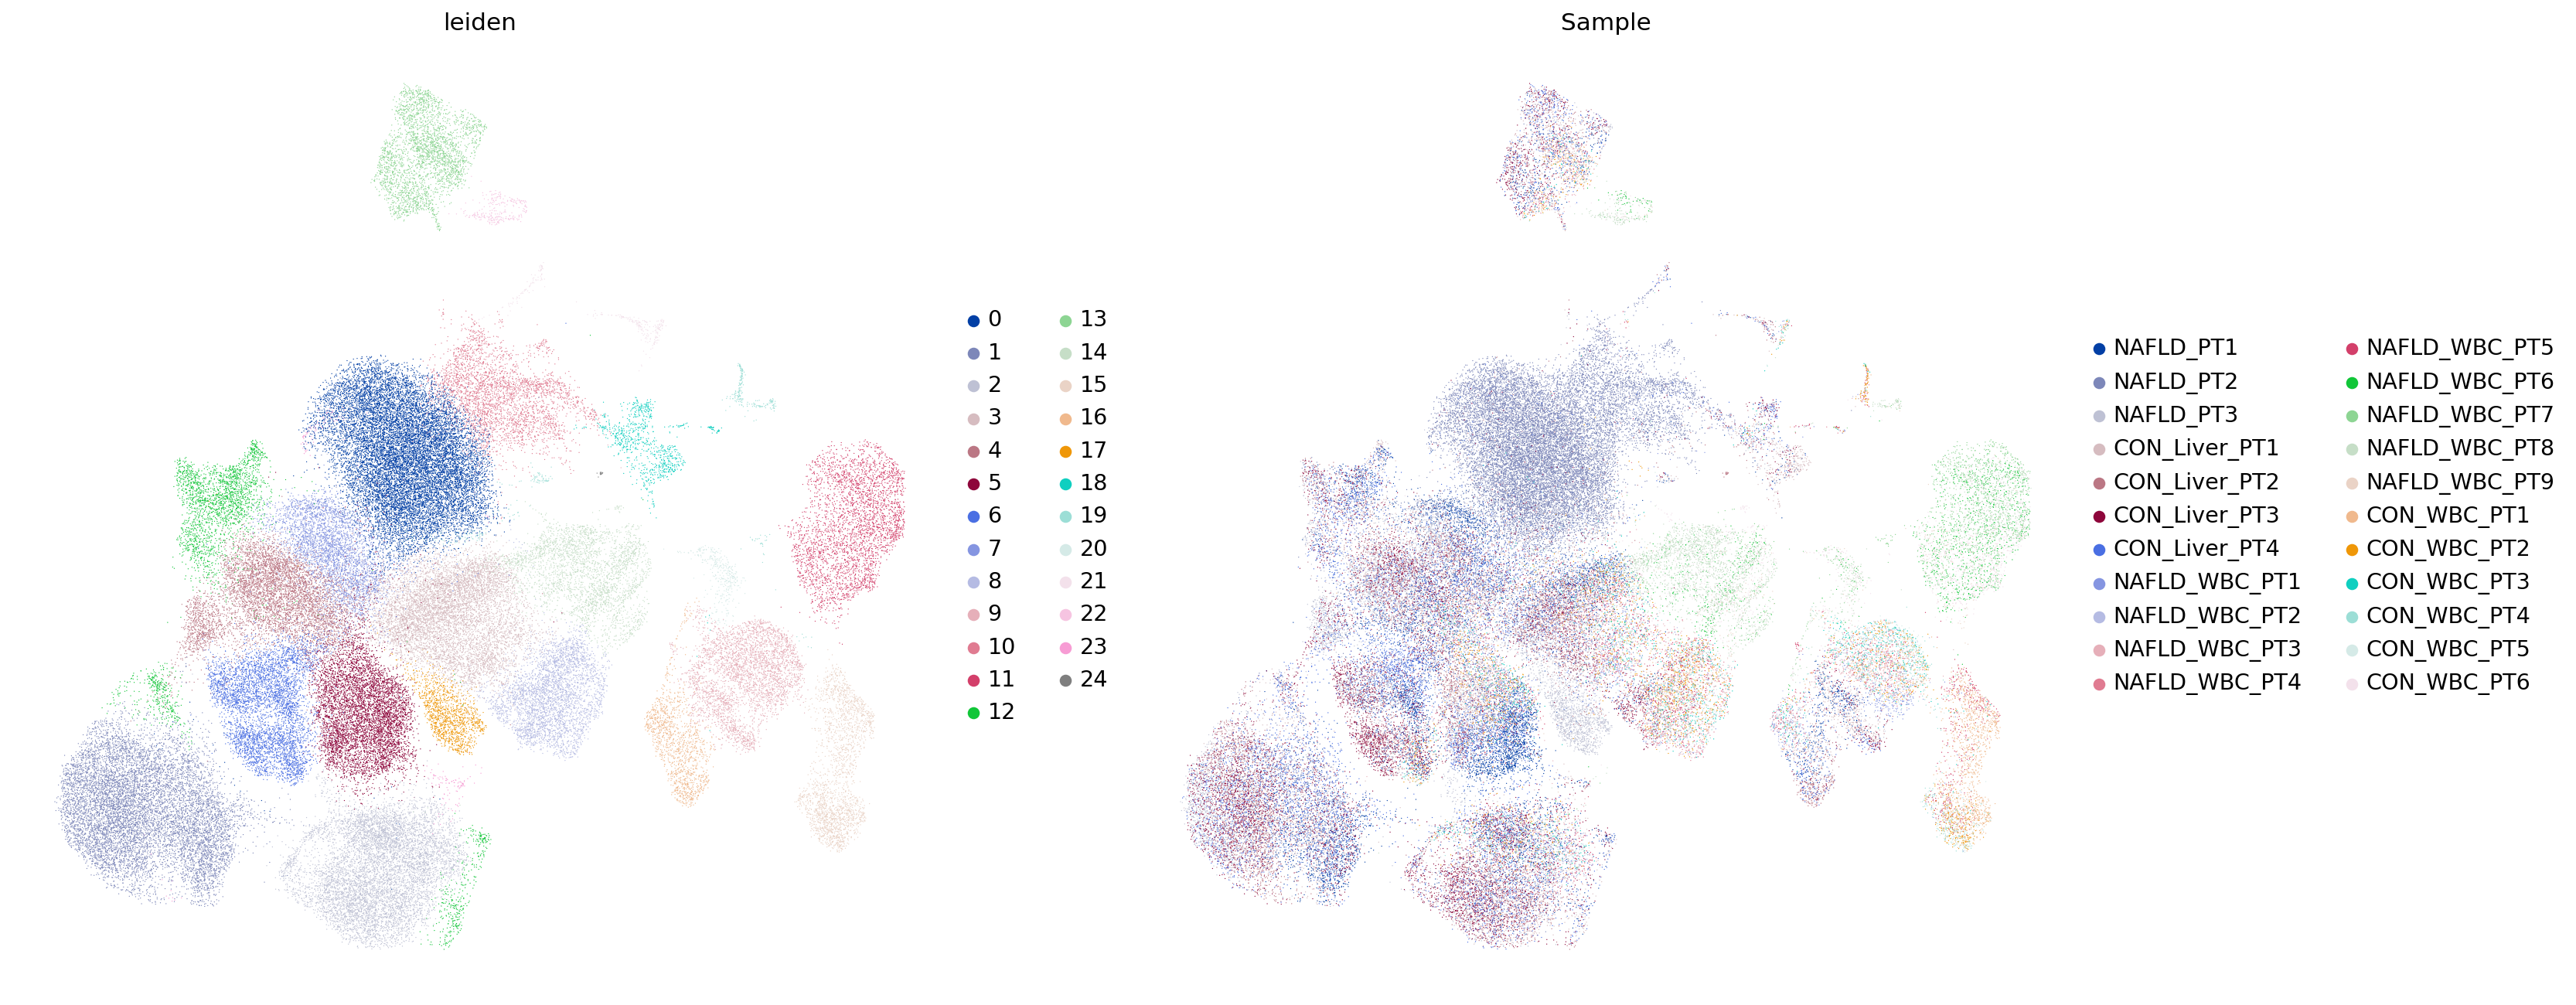

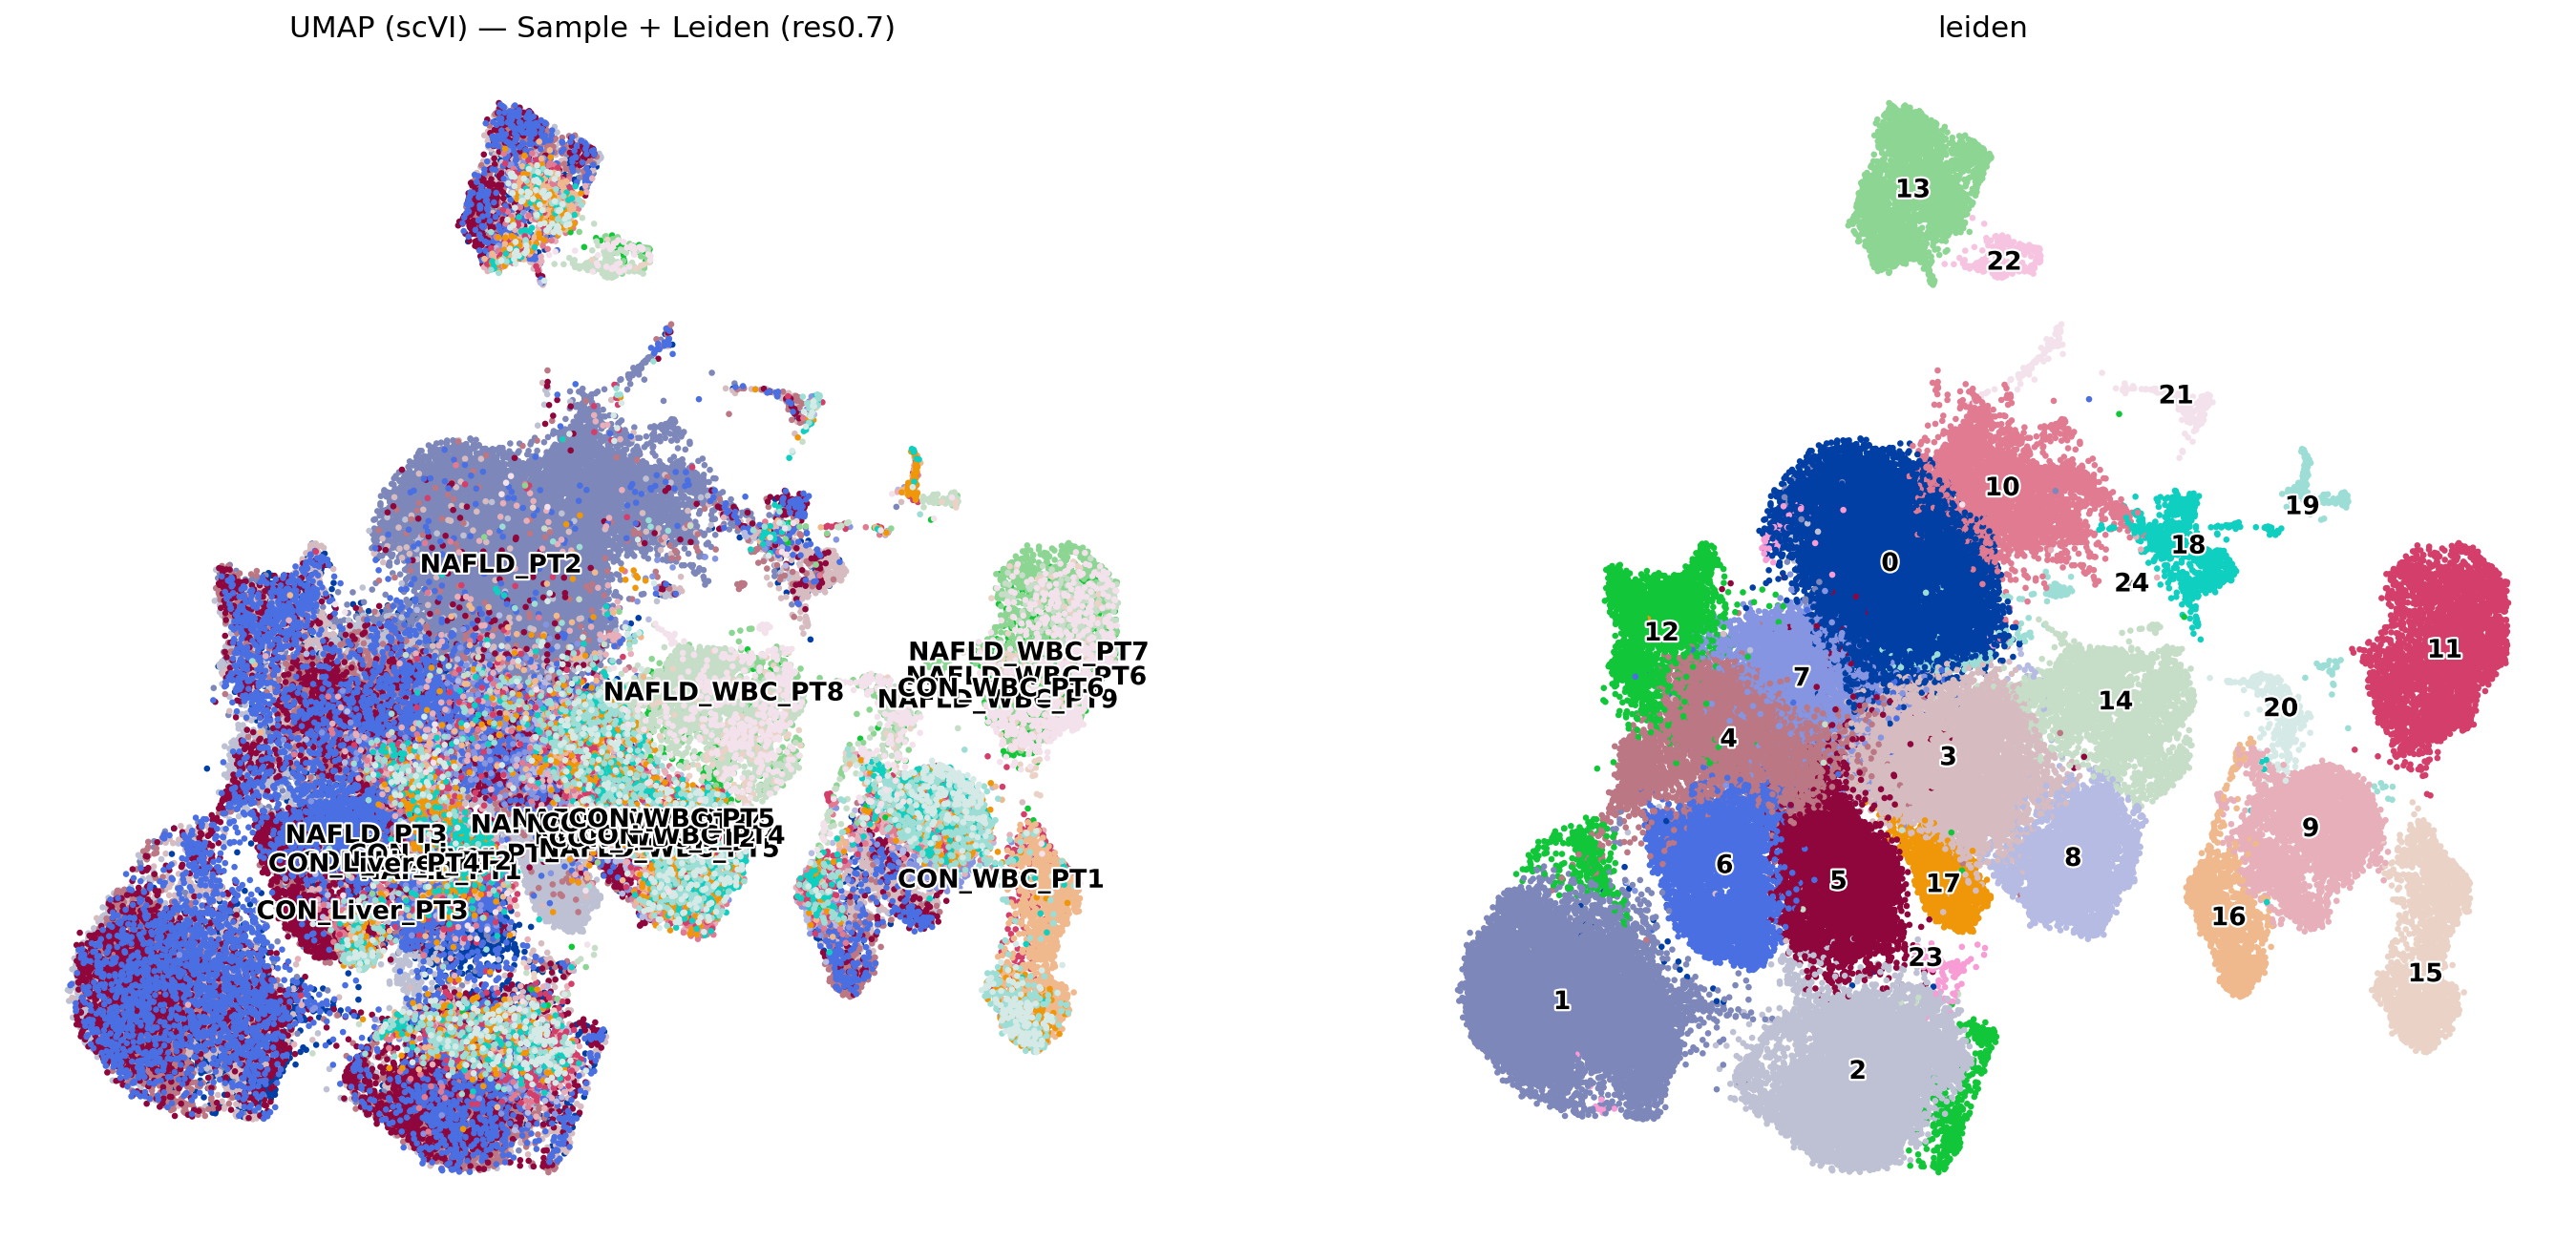

In [21]:
# ==========================================
# Step 5 — UMAP plots (save + show)
# ==========================================
img_tag = "_color"  # tag used in filenames

# View in Notebook
sc.pl.umap(adata, color=["leiden", "Sample"], frameon=False)

# Saved to /home/tsaliu/david_figures/
sc.pl.umap(
    adata,
    color=["Sample", "leiden"],
    legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    frameon=False,
    size=35,
    title="UMAP (scVI) — Sample + Leiden (res0.7)",
    save=f"_{FIG_PREFIX}__umap_scvi__sample_leiden__res0p7.png",
)

plt.show()

In [22]:
# ==================================================
# Step 6 — Marker discovery (Scanpy + scVI DE tables)
# ==================================================
# Scanpy (Wilcoxon) markers
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")

# Rank genes plot (exact filename)
fig = sc.pl.rank_genes_groups(
    adata,
    n_genes=20,
    sharey=False,
    return_fig=True,
    show=False,
)
save_scanpy_fig(fig, f"{FIG_PREFIX}__rank_genes__leiden__wilcoxon__res{str(LEIDEN_RES).replace('.','p')}.png")

markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 0.5)]

# scVI differential expression by Leiden cluster
markers_scvi = model.differential_expression(groupby="leiden")
markers_scvi = markers_scvi[(markers_scvi["is_de_fdr_0.05"]) & (markers_scvi.lfc_mean > 0.5)]


KeyboardInterrupt: 

In [ ]:
# =====================================================
# Step 7 — Feature plots on scVI normalized expression
# =====================================================
# On-screen
sc.pl.umap(
    adata,
    color=["NAMPT", "CD14"],
    frameon=False,
    layer="scvi_normalized",
    vmax=5,
)

# Exact saved figure
fig = sc.pl.umap(
    adata,
    color=["NAMPT", "CD14"],
    frameon=False,
    layer="scvi_normalized",
    vmax=5,
    title="UMAP (scVI) — NAMPT, CD14",
    return_fig=True,
    show=False,
)
save_scanpy_fig(fig, f"{FIG_PREFIX}__umap_scvi__features__NAMPT_CD14.png")

In [ ]:
# ===================================================
# Step 8 — Save marker outputs (CSVs)
# ===================================================
OUTDIR = Path("/home/tsaliu/marker_outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

markers.to_csv(OUTDIR / f"{FIG_PREFIX}__markers_wilcoxon_filtered__res{str(LEIDEN_RES).replace('.','p')}.csv", index=False)
markers_scvi.to_csv(OUTDIR / f"{FIG_PREFIX}__markers_scvi_filtered__res{str(LEIDEN_RES).replace('.','p')}.csv", index=False)

# Optional quick check for a specific marker in the Scanpy table
_ = markers.loc[markers["names"] == "TRDC"]

In [ ]:
# ======================================================
# Step 9 — CellTypist install note (run only if needed)
# ======================================================
# If CellTypist is already installed in this environment, this is redundant:
# !pip install -U celltypist

In [ ]:
# ==========================================
# Step 10 — CellTypist: prep + model download
# ==========================================
import celltypist
from celltypist import models

# CellTypist expects gene symbols in var_names (ensure adata.raw.var_names are symbols)
print("Example genes (raw):", adata.raw.var_names[:5])

models.download_models(force_update=False, model=["Immune_All_Low.pkl"])

# Ensure unique obs_names
if not adata.obs_names.is_unique:
    adata.obs_names_make_unique()

# Build CellTypist input object using raw expression + raw gene names
adata_ct = adata.copy()
adata_ct.X = adata.raw.X
adata_ct.var_names = adata.raw.var_names

In [ ]:
# ==========================================
# Step 11 — CellTypist annotation (with voting)
# ==========================================
pred_immune = celltypist.annotate(
    adata_ct,
    model="Immune_All_Low.pkl",
    majority_voting=True,
    over_clustering=adata.obs["leiden"].astype(str).to_numpy(),
)

df_labels = pred_immune.predicted_labels

In [ ]:
# ==========================================================
# Step 12 — Confidence scores + add results into adata.obs
# ==========================================================
if not hasattr(pred_immune, "probability_matrix"):
    raise AttributeError("CellTypist output has no probability_matrix; cannot compute confidence.")

prob = pred_immune.probability_matrix  # typically cells x classes (DataFrame)
ct_conf = prob.max(axis=1)  # per-cell confidence (max class probability)

# Align by cell index
adata.obs["ct_conf"] = ct_conf.reindex(adata.obs_names).values
adata.obs["ct_majority"] = df_labels["majority_voting"].values

In [ ]:
# ==========================================
# Step 13 — Visualize CellTypist results on UMAP
# ==========================================
# On-screen
sc.pl.umap(adata, color=["ct_majority", "ct_conf", "Sample"], frameon=False)

# Exact saved figure
fig = sc.pl.umap(
    adata,
    color=["ct_majority", "ct_conf", "Sample"],
    frameon=False,
    title="UMAP (scVI) — CellTypist label, confidence, sample",
    return_fig=True,
    show=False,
)
save_scanpy_fig(fig, f"{FIG_PREFIX}__umap_scvi__celltypist__labels_conf_sample.png")

In [ ]:
# ==================================================
# Step 14 — (Optional) Check for a specific saved file
# ==================================================
outfile = FIG_DIR / f"{FIG_PREFIX}__umap_scvi__celltypist__labels_conf_sample.png"
print("Expected file path:", outfile)
print("Exists?:", outfile.exists())
if outfile.exists():
    print("File size (bytes):", outfile.stat().st_size)

In [ ]:
# ============================================================
# Step 15: Confirm whether low-confidence cells are non-immune (PTPRC/CD45)
#   - Requires: adata.raw exists and contains "PTPRC"
#   - Requires: adata.obs has "ct_conf" (your CellTypist confidence) OR "ct_conf_mv"
# ============================================================
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

# Choose which confidence column to use
if "ct_conf_mv" in adata.obs.columns:
    conf_col = "ct_conf_mv"   # preferred if you computed it
elif "ct_conf" in adata.obs.columns:
    conf_col = "ct_conf"      # your current confidence
else:
    raise ValueError("No CellTypist confidence column found. Expected adata.obs['ct_conf'] or ['ct_conf_mv'].")

# Ensure unique cell IDs (required for any alignment/index-based operations)
if not adata.obs_names.is_unique:
    adata.obs_names_make_unique()

# Compute PTPRC log1p expression from adata.raw
if adata.raw is None:
    raise ValueError("adata.raw is None. Expected adata.raw to contain log1p-normalized expression.")
if "PTPRC" not in adata.raw.var_names:
    raise ValueError("PTPRC not found in adata.raw.var_names. Cannot do immune vs non-immune split by CD45/PTPRC.")

ptprc = adata.raw[:, "PTPRC"].X
try:
    ptprc = ptprc.toarray().ravel()
except Exception:
    ptprc = ptprc.A.ravel() if hasattr(ptprc, "A") else np.ravel(ptprc)

adata.obs["PTPRC_log1p"] = ptprc

# Define low-confidence mask
adata.obs["ct_lowconf"] = adata.obs[conf_col] < 0.5

# Define non-immune by PTPRC (tune threshold after looking at distributions/plots)
ptprc_thr = 0.2
adata.obs["is_nonimmune_ptprc"] = adata.obs["PTPRC_log1p"] < ptprc_thr

print("Using confidence column:", conf_col)
print("\nPTPRC_log1p summary:")
print(adata.obs["PTPRC_log1p"].describe())
print("\nConfidence summary:")
print(adata.obs[conf_col].describe())
print("\nLow-confidence cells (<0.5):", int(adata.obs["ct_lowconf"].sum()))
print("Non-immune by PTPRC (<0.2):", int(adata.obs["is_nonimmune_ptprc"].sum()))

# Overlap table (row-normalized): if lowconf is mostly PTPRC-low, that supports your hypothesis
overlap = pd.crosstab(
    adata.obs["ct_lowconf"],
    adata.obs["is_nonimmune_ptprc"],
    rownames=["ct_lowconf"],
    colnames=["is_nonimmune_ptprc"],
    normalize="index",
)
print("\nOverlap (row-normalized): ct_lowconf vs is_nonimmune_ptprc")
print(overlap)

# Visual confirmation on the existing global UMAP (does not recompute UMAP)
sc.pl.umap(
    adata,
    color=["PTPRC_log1p", "is_nonimmune_ptprc", conf_col, "ct_lowconf"],
    frameon=False,
    show=False,
    save="_step15_ptprc_lowconf_check.png",
)
plt.close()

In [ ]:
# ============================================================
# Step 16: Marker check on low-confidence cells (supports "non-immune liver" interpretation)
#   - Compares mean log1p expression in lowconf vs highconf
# ============================================================
marker_sets = {
    "Hepatocyte": ["ALB", "APOA1", "APOB", "TTR"],
    "Cholangiocyte": ["KRT19", "KRT7", "EPCAM"],
    "Endothelial": ["PECAM1", "VWF", "KDR"],
    "Fibroblast_Stellate": ["COL1A1", "COL1A2", "DCN", "LUM", "RGS5"],
}

present = {k: [g for g in v if g in adata.raw.var_names] for k, v in marker_sets.items()}
print("\nMarkers present in this dataset:")
for k, v in present.items():
    print(f"  {k}: {v}")

mask_low = adata.obs["ct_lowconf"].to_numpy()
mask_high = ~mask_low

def mean_marker_expr(gene_list, mask):
    if len(gene_list) == 0:
        return np.nan
    X = adata.raw[:, gene_list].X
    try:
        X = X.toarray()
    except Exception:
        X = X.A if hasattr(X, "A") else np.asarray(X)
    return float(X[mask, :].mean())

rows = []
for k, genes in present.items():
    rows.append({
        "marker_set": k,
        "n_genes_used": len(genes),
        "mean_lowconf": mean_marker_expr(genes, mask_low),
        "mean_highconf": mean_marker_expr(genes, mask_high),
    })

marker_summary = pd.DataFrame(rows)
marker_summary["low_minus_high"] = marker_summary["mean_lowconf"] - marker_summary["mean_highconf"]
marker_summary = marker_summary.sort_values("low_minus_high", ascending=False)

print("\nMarker enrichment (lowconf vs highconf):")
print(marker_summary)

marker_summary.to_csv("step16_lowconf_marker_enrichment.csv", index=False)
print("\nSaved: step16_lowconf_marker_enrichment.csv")

In [ ]:
# ============================================================
# Step 17: Split into immune vs non-immune subsets (PTPRC-based)
# ============================================================
adata_immune = adata[~adata.obs["is_nonimmune_ptprc"]].copy()
adata_nonimmune = adata[adata.obs["is_nonimmune_ptprc"]].copy()

print("\nImmune subset n_cells:", adata_immune.n_obs)
print("Non-immune subset n_cells:", adata_nonimmune.n_obs)

# (Optional) Save subset membership on full object for later
adata.obs["subset_ptprc"] = np.where(adata.obs["is_nonimmune_ptprc"], "nonimmune", "immune")

In [ ]:
# ============================================================
# Step 18: Recompute Leiden within each subset using X_scVI
#   - This explains why global Leiden (24 clusters) may collapse into fewer cell types
# ============================================================
# Immune subset clustering
sc.pp.neighbors(adata_immune, use_rep="X_scVI")
sc.tl.umap(adata_immune)
sc.tl.leiden(adata_immune, resolution=0.7, key_added="leiden_immune")
print("\nImmune Leiden clusters:", adata_immune.obs["leiden_immune"].nunique())

sc.pl.umap(
    adata_immune,
    color=["leiden_immune", "Sample"],
    frameon=False,
    show=False,
    save="_step18_umap_immune_leiden.png",
)
plt.close()

# Non-immune subset clustering
sc.pp.neighbors(adata_nonimmune, use_rep="X_scVI")
sc.tl.umap(adata_nonimmune)
sc.tl.leiden(adata_nonimmune, resolution=0.7, key_added="leiden_nonimmune")
print("Non-immune Leiden clusters:", adata_nonimmune.obs["leiden_nonimmune"].nunique())

sc.pl.umap(
    adata_nonimmune,
    color=["leiden_nonimmune", "Sample"],
    frameon=False,
    show=False,
    save="_step18_umap_nonimmune_leiden.png",
)
plt.close()

In [ ]:
# ============================================================
# Step 19: CellTypist on immune subset (immune model)
#   - Uses majority voting with subset-specific Leiden
#   - Adds: ct_majority_immune, ct_conf_immune (if probability_matrix is available)
# ============================================================
import celltypist
from celltypist import models

# Prefer higher-granularity immune model if available; otherwise use Low
immune_model = "Immune_All_High.pkl"
try:
    models.download_models(force_update=False, model=[immune_model])
except Exception:
    immune_model = "Immune_All_Low.pkl"
    models.download_models(force_update=False, model=[immune_model])

# Build CellTypist input from subset raw (log1p) matrix
adata_immune_ct = sc.AnnData(
    X=adata_immune.raw.X,
    obs=adata_immune.obs.copy(),
    var=pd.DataFrame(index=pd.Index(adata_immune.raw.var_names).astype(str)),
)
adata_immune_ct.obs_names = adata_immune.obs_names

pred_imm = celltypist.annotate(
    adata_immune_ct,
    model=immune_model,
    majority_voting=True,
    over_clustering=adata_immune.obs["leiden_immune"].astype(str).to_numpy(),
)

df_imm = pred_imm.predicted_labels
adata_immune.obs["ct_majority_immune"] = df_imm["majority_voting"].values

# Confidence (if probability_matrix exists)
if hasattr(pred_imm, "probability_matrix") and pred_imm.probability_matrix is not None:
    prob_imm = pred_imm.probability_matrix
    mv_imm = df_imm["majority_voting"].reindex(prob_imm.index).astype(str)
    col_idx_imm = prob_imm.columns.get_indexer(mv_imm)
    adata_immune.obs["ct_conf_immune"] = prob_imm.to_numpy()[np.arange(prob_imm.shape[0]), col_idx_imm]
else:
    adata_immune.obs["ct_conf_immune"] = np.nan
    print("NOTE: probability_matrix missing for immune subset; ct_conf_immune set to NaN.")

print("\nImmune CellTypist model used:", immune_model)
print("Immune CellTypist labels (top 20):")
print(adata_immune.obs["ct_majority_immune"].value_counts().head(20))

sc.pl.umap(
    adata_immune,
    color=["ct_majority_immune", "ct_conf_immune", "leiden_immune"],
    frameon=False,
    show=False,
    save="_step19_umap_immune_celltypist.png",
)
plt.close()

pd.crosstab(adata_immune.obs["leiden_immune"], adata_immune.obs["ct_majority_immune"]).to_csv(
    "step19_immune_leiden_by_celltypist.csv"
)
print("Saved: step19_immune_leiden_by_celltypist.csv")

In [ ]:
# ============================================================
# Step 20: CellTypist on non-immune subset (liver/tissue model if available)
#   - Automatically selects a liver model if one exists in models_description()
#   - Otherwise falls back to a general human model if available; else skips
# ============================================================
desc = models.models_description()

# Extract available .pkl model names from the description text
import re
pkl_names = re.findall(r'([A-Za-z0-9_.-]+\.pkl)', desc)

liver_candidates = [m for m in pkl_names if "liver" in m.lower()]
human_all_candidates = [m for m in pkl_names if ("human" in m.lower() and "all" in m.lower())]

nonimmune_model = liver_candidates[0] if liver_candidates else (human_all_candidates[0] if human_all_candidates else None)

print("\nDetected liver model candidates:", liver_candidates[:10])
print("Detected human-all candidates:", human_all_candidates[:10])
print("Selected non-immune CellTypist model:", nonimmune_model)

if nonimmune_model is None:
    print("WARNING: No liver/tissue or general human CellTypist model detected. Skipping non-immune CellTypist.")
    adata_nonimmune.obs["ct_majority_nonimmune"] = pd.NA
    adata_nonimmune.obs["ct_conf_nonimmune"] = np.nan
else:
    models.download_models(force_update=False, model=[nonimmune_model])

    adata_nonimmune_ct = sc.AnnData(
        X=adata_nonimmune.raw.X,
        obs=adata_nonimmune.obs.copy(),
        var=pd.DataFrame(index=pd.Index(adata_nonimmune.raw.var_names).astype(str)),
    )
    adata_nonimmune_ct.obs_names = adata_nonimmune.obs_names

    pred_nonimm = celltypist.annotate(
        adata_nonimmune_ct,
        model=nonimmune_model,
        majority_voting=True,
        over_clustering=adata_nonimmune.obs["leiden_nonimmune"].astype(str).to_numpy(),
    )

    df_nonimm = pred_nonimm.predicted_labels
    adata_nonimmune.obs["ct_majority_nonimmune"] = df_nonimm["majority_voting"].values

    if hasattr(pred_nonimm, "probability_matrix") and pred_nonimm.probability_matrix is not None:
        prob_nonimm = pred_nonimm.probability_matrix
        mv_nonimm = df_nonimm["majority_voting"].reindex(prob_nonimm.index).astype(str)
        col_idx_nonimm = prob_nonimm.columns.get_indexer(mv_nonimm)
        adata_nonimmune.obs["ct_conf_nonimmune"] = prob_nonimm.to_numpy()[np.arange(prob_nonimm.shape[0]), col_idx_nonimm]
    else:
        adata_nonimmune.obs["ct_conf_nonimmune"] = np.nan
        print("NOTE: probability_matrix missing for non-immune subset; ct_conf_nonimmune set to NaN.")

    print("\nNon-immune CellTypist labels (top 20):")
    print(adata_nonimmune.obs["ct_majority_nonimmune"].value_counts().head(20))

    sc.pl.umap(
        adata_nonimmune,
        color=["ct_majority_nonimmune", "ct_conf_nonimmune", "leiden_nonimmune"],
        frameon=False,
        show=False,
        save="_step20_umap_nonimmune_celltypist.png",
    )
    plt.close()

    pd.crosstab(adata_nonimmune.obs["leiden_nonimmune"], adata_nonimmune.obs["ct_majority_nonimmune"]).to_csv(
        "step20_nonimmune_leiden_by_celltypist.csv"
    )
    print("Saved: step20_nonimmune_leiden_by_celltypist.csv")

In [ ]:
# ============================================================
# Step 21: Write subset-specific results back onto the full adata
#   - Adds columns without changing earlier pipeline steps
# ============================================================
# Leiden (subset-specific)
adata.obs["leiden_immune"] = pd.NA
adata.obs["leiden_nonimmune"] = pd.NA
adata.obs.loc[adata_immune.obs_names, "leiden_immune"] = adata_immune.obs["leiden_immune"].astype(str).values
adata.obs.loc[adata_nonimmune.obs_names, "leiden_nonimmune"] = adata_nonimmune.obs["leiden_nonimmune"].astype(str).values

# CellTypist (subset-specific)
adata.obs["ct_majority_immune"] = pd.NA
adata.obs["ct_conf_immune"] = np.nan
adata.obs.loc[adata_immune.obs_names, "ct_majority_immune"] = adata_immune.obs["ct_majority_immune"].values
adata.obs.loc[adata_immune.obs_names, "ct_conf_immune"] = adata_immune.obs["ct_conf_immune"].values

adata.obs["ct_majority_nonimmune"] = pd.NA
adata.obs["ct_conf_nonimmune"] = np.nan
adata.obs.loc[adata_nonimmune.obs_names, "ct_majority_nonimmune"] = adata_nonimmune.obs["ct_majority_nonimmune"].values
adata.obs.loc[adata_nonimmune.obs_names, "ct_conf_nonimmune"] = adata_nonimmune.obs["ct_conf_nonimmune"].values

print("\nAdded columns to adata.obs:")
print([c for c in [
    "PTPRC_log1p", "is_nonimmune_ptprc", "ct_lowconf",
    "leiden_immune", "leiden_nonimmune",
    "ct_majority_immune", "ct_conf_immune",
    "ct_majority_nonimmune", "ct_conf_nonimmune"
] if c in adata.obs.columns])

# Optional: Save a combined UMAP on the original embedding
sc.pl.umap(
    adata,
    color=["subset_ptprc", "ct_majority_immune", "ct_majority_nonimmune"],
    frameon=False,
    show=False,
    save="_step21_global_umap_subset_labels.png",
)
plt.close()

# Optional: Save outputs (safe; creates new files)
adata.obs.to_csv("step21_NAFLD_obs_subset_annotations.csv")
adata.write_h5ad("step21_NAFLD_with_subset_leiden_celltypist.h5ad")
print("\nSaved:")
print("  step21_NAFLD_obs_subset_annotations.csv")
print("  step21_NAFLD_with_subset_leiden_celltypist.h5ad")
